MIDA Gondara and Wang(2018) in Python (using PyTorch)
https://arxiv.org/abs/1705.02737
https://gist.github.com/lgondara/18387c5f4d745673e9ca8e23f3d7ebd3 

# 1. Loading Dataset

## 1.1. Load a dataset and introduce missingness

Dataset used: Shuttle Dataset (https://archive.ics.uci.edu/ml/datasets/Statlog+(Shuttle)

### 1.1.1. Load the dataset and store it as dataframe(numeric)

In [1]:
import pandas as pd
import utils

In [2]:
#Test
filename = "data/shuttle/shuttle_trn"
df = utils.get_dataframe_from_csv(filename).iloc[:,:-1]  #remove label

INFO:root:Input filename has to be space separated data


In [3]:
# #Test
# filename = "data/shuttle/shuttle_trn_debug"
# train_df = utils.get_dataframe_from_csv(filename).iloc[:,:-1]  #remove label

In [4]:
df.head()

,50,21,77,0,28,0.1,27,48,22
0,55,0,92,0,0,26,36,92,56
1,53,0,82,0,52,-5,29,30,2
2,37,0,76,0,28,18,40,48,8
3,37,0,79,0,34,-26,43,46,2
4,85,0,88,-4,6,1,3,83,80


### 1.1.2. Inducing missingness

After dataset loading, start with inducing missingness. 

To start off, introduce simple random missing patterns (Missing Completely At Random), i.e. sample half of the variables and set observations in those variables to missing if an appended random uniform vector has value less than a certain threshhold. WIth threshold of 0.2, the procedure should introduce about 20% missingness.

In [5]:
#test
df1 = df.copy()
df2 = utils.induce_missingness(df1,logger_level=20)

INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.79


In [6]:
df1.head()

,50,21,77,0,28,0.1,27,48,22
0,55,0,92,0,0,26,36,92,56
1,53,0,82,0,52,-5,29,30,2
2,37,0,76,0,28,18,40,48,8
3,37,0,79,0,34,-26,43,46,2
4,85,0,88,-4,6,1,3,83,80


In [7]:
df2.head()

,50,21,77,0,28,0.1,27,48,22
0,55,0,92,0,NaN,26,NaN,NaN,NaN
1,53,0,82,0,52.0,-5,29.0,30.0,2.0
2,37,0,76,0,28.0,18,40.0,48.0,8.0
3,37,0,79,0,34.0,-26,43.0,46.0,2.0
4,85,0,88,-4,6.0,1,3.0,83.0,80.0


### 1.1.3. Create Train-Test split

Create 70% training data and 30%  test data which includes missingness and a test data without missingness so we can calculate performance. 

In [8]:
#Test
train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df1, test_perc=0.3, logger_level=20)
print(train_df.head())
print(test_df.head())
print(full_test_df.head())

INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.79
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs


       50  21  77  0    28  0.1    27    48    22
38461  37   0  77  0  36.0   -2  40.0  41.0   2.0
41706  51   0  87 -2  52.0    1  36.0  35.0   0.0
20104  48   0  81  0  46.0   -8  32.0  34.0   2.0
25872  55  -2  78  0  10.0    0  23.0  68.0  46.0
42524  37   0  95  0  20.0    2  57.0  74.0  16.0
       50  21   77  0    28  0.1    27    48    22
14601  44   0   89  0  44.0    4  45.0  45.0   0.0
3043   49   0   95  1  50.0    7  47.0  46.0   0.0
5667   37   0  106  5   NaN    0   NaN   NaN   NaN
36855  37   0   75 -2  26.0  -15  38.0  49.0  10.0
32389  55   0   77  5  28.0    0  22.0  49.0  26.0
       50  21   77  0  28  0.1  27  48  22
14601  44   0   89  0  44    4  45  45   0
3043   49   0   95  1  50    7  47  46   0
5667   37   0  106  5  18    0  69  88  18
36855  37   0   75 -2  26  -15  38  49  10
32389  55   0   77  5  28    0  22  49  26


# 2. Modelling

Proceed to modelling.

In R:
Start with initializing 'h2o' package and then reading the training and test datasets as the 'h2o's supported format.
Then run imputation model multiple times as each new start would initialize the weights with different values.<br>
Info at: <br>
[h2o](https://cran.r-project.org/web/packages/h2o/h2o.pdf) package offers an easy to use function for implementing autoencoders. 
More information is available at this [link](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/DeepLearningBooklet.pdf).

In Python: Using PyTorch to create the DAE, and train using the Adam optimizer from PyTorch

In [10]:
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.functional as F

In [11]:
#Settings for device, randomization seed, default tensor type, kwargs for memory #DevSeedTensKwargs
RANDOM_SEED = 18
np.random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    kwargs = {'num_workers':4, 'pin_memory' :True}
else:
    device = 'cpu'
    torch.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.FloatTensor)
    kwards = {}

In [12]:
import dataset_module

In [13]:
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe

In [14]:
len(trainset)

30449

In [15]:
import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()))

In [16]:
net

DenoisingAutoEncoder(
  (drop_layer): Dropout(p=0.5)
  (linear_layer_list): ModuleList(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=23, bias=True)
    (2): Linear(in_features=23, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=23, bias=True)
    (4): Linear(in_features=23, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=9, bias=True)
  )
)

# 3. Training

In [17]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, dropout_at_layers=[1], input_dropout=0.5)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [18]:
'''
TO DO:
:- Nesterov Momentum + Adam- Pytorch? Decay factor?
'''
import os
from tqdm import tqdm_notebook as tqdm
def train_model(start_steps = 0, end_steps = 5, net=None, model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout", train_loader = train_loader, val_loader = val_loader, logger_level = 20):
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)

    NaN_flag = False
    
    for epoch in tqdm(range(start_steps, end_steps)):
        count = epoch-start_steps+1
        net.train()
        #Epoch begins
        epoch_loss = 0.0
        for x, d in tqdm(train_loader):
            # Normalize between [0,1] for better convergence 
            original_x = x
            x[torch.isnan(x)]=0   #If an entire column is zero, division by 0, replace NaNs with zero
            d[torch.isnan(d)]=0 

            optimizer.zero_grad()
            x = x.to(device)
            with torch.no_grad():
                d = d.to(device)
            y = net(x)
            loss = torch.sqrt(criterion(y, d))   #RMSE Loss   
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            #Break if NaN encountered
            if torch.isnan(loss) or torch.isinf(loss):
                logging.info(f"Loss value: {loss.item()}")
                logging.info("NaN/inf occured at:")
                logging.info(f"{x}\n")
                logging.info(f"{d}\n")
                logging.info(f"Original x was : {original_x}")
                NaN_flag = True
                break

            logging.debug(f"Count: {count}, Loss :{loss}")
            
        if NaN_flag: break   #Stop training if NaN encountered
        
        #Print to screen every few epochs    
        if count%LOG_INTERVAL == 0:
            print(f"Epoch number:{epoch} Loss: {epoch_loss:.4f}")  
            
        #Training artifacts
        if model_name not in os.listdir():
            os.makedirs(model_name+"/artifacts/saved_model/")

        #Write to loss file every epoch
        with open(model_name+"/artifacts/loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {epoch_loss:.4f}\n")
            
        #Validation curve
        val_loss = 0.0
        net.eval()
        for x,d in val_loader:
            x[torch.isnan(x)]=0
            d[torch.isnan(d)]=0
            x = x.to(device)
            with torch.no_grad():
                d= d.to(device)
            y = net(x)
            loss = torch.sqrt(criterion(y,d))
            val_loss+=loss
        net.train()
        #Write Val loss to file every epoch
        with open(model_name+"/artifacts/val_loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {val_loss:.4f}\n")
        
        #Save model every few epochs
        if epoch%SAVE_INTERVAL== 0:
            torch.save(net.state_dict(),f"./{model_name}/artifacts/saved_model/model_at_epoch{epoch}")
        #Epoch Ends

In [18]:
model_name = "Shuttle_Dataset_Dropout_at_layer_1_DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout"

In [19]:
model_name = "check"

In [20]:
train_model(0,3, net, model_name, train_loader=train_loader, val_loader=val_loader)

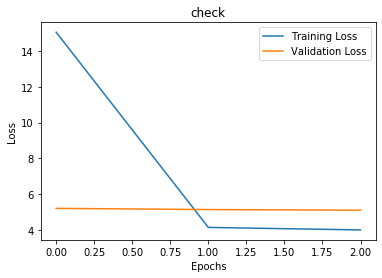

In [22]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

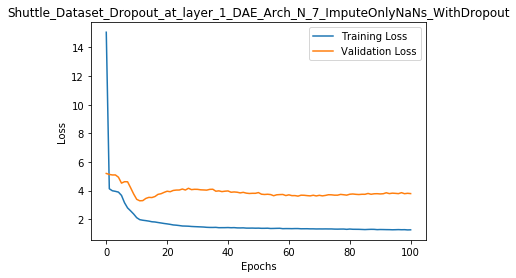

In [21]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [ ]:
# '''Remove folder before training again'''
# import shutil
# shutil.rmtree(model_name)

Learning Rate annealing:- Maybe need a smaller learning rate after a while? 
Nesterov momentum:- Check paper to see if all the features have been implemented exactly (like Nesterov?)
              
Experiments to try:
1. Plot different values for different architectures.
2. Try feeding in with just the imputed values instead of the whole predicted data.
3. Try without dropout.

Features needed:

1. Printing out the denormalized data in prediction - DONE
2. Store the ids of NaNs before filling them up with placeholders - Not Needed, wrote a better TEST FUNCTION
3. Do 70/30 Split before training, testing - DONE
4. Add provision in model for changing theta params - DONE
5. Add provision for removing dropout - DONE
6. Plotting Loss function - DONE

In [ ]:
# Saving model

#torch.save(optimizer.state_dict(), filename)
#optimizer.load_state_dict(torch.load(filename))

# Modelling Loading from saved point

# model =  Modelling.DenoisingAutoEncoder(len(trainset.variables()))
# model.load_state_dict(torch.load("./artifacts/saved_model_epoch50"))
# model.eval()

In [ ]:
#Tweaking the learning rate to improve convergence speed
# optimizer = Adam(net.parameters(), LR)

# 4. Testing

In [22]:
net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

tensor([0.1182, 0.4963, 0.6100, 0.5117, 0.3514, 0.5173, 0.6991, 0.6393, 0.5807])
tensor([0.1042, 0.4964, 0.6087, 0.5128, 0.3590, 0.5127, 0.7034, 0.6324, 0.5756])


In [30]:
net = net.eval()
print(trainset.get_denormalized_data((net(trainset[0][0].detach()))))
print(trainset.get_denormalized_data(trainset[0][0]))

         50        21         77        0         28         0.1         27  \
0  38.34362 -0.319336  77.122063 -8.46875  31.296799  120.426758  39.493546   

          48       22  
0  45.269958  5.22229  
     50   21    77         0    28  0.1    27    48   22
0  37.0  0.0  77.0  0.000244  36.0 -2.0  40.0  41.0  2.0


In [24]:
import pandas as pd
import torch
def test_model(net=None, test_df= None, trainset=None, device =None, logger_level=20):
    """
    Function to evaluate the model on test set
    Should meet the following requirements:
        :-trainset - should be an object of class DataSetForImputation
        :-test_df - should be a Pandas dataframe with NaNs (if there are no NaNs, the same will be returned)
        :-net - should be an object of DenoisingAutoEncoder
    """
    assert isinstance(net, Modelling.DenoisingAutoEncoder)
    assert isinstance(test_df, pd.DataFrame)
    assert isinstance(trainset, dataset_module.DataSetForImputation)
    
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)
    
    NaN_test_df = test_df.reset_index(drop=True)  #Dropping index so that everything is reindexed from 0
       
    test_df = test_df.apply(lambda x: x.fillna(x.mean()), axis=0)
    test_df_norm = (test_df- trainset.min_df)/(trainset.max_df-trainset.min_df)
    test_df_tensor = torch.tensor(test_df_norm.values).to(device)
        
    net = net.eval()
    logging.debug(f"{test_df_tensor.shape}")
    pred = net(test_df_tensor)
     
    pred =  trainset.get_denormalized_data(pred)  #Predicted dataframe from the mode    
    
    # Replace the NaNs in the original test_df with newly imputed values
    final_pred = NaN_test_df.where(~NaN_test_df.isna(), other = pred)
    logging.debug(f"final_pred:\n {final_pred.head()}")
    
    return final_pred

In [32]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,50,21,77,0,28,0.1,27,48,22
0,44,0,89,0,44.000000,4,45.000000,45.000000,0.000000
1,49,0,95,1,50.000000,7,47.000000,46.000000,0.000000
2,37,0,106,5,36.738962,0,43.489025,53.340345,11.648615
3,37,0,75,-2,26.000000,-15,38.000000,49.000000,10.000000
4,55,0,77,5,28.000000,0,22.000000,49.000000,26.000000


In [33]:
full_test_df.head()

,50,21,77,0,28,0.1,27,48,22
14601,44,0,89,0,44,4,45,45,0
3043,49,0,95,1,50,7,47,46,0
5667,37,0,106,5,18,0,69,88,18
36855,37,0,75,-2,26,-15,38,49,10
32389,55,0,77,5,28,0,22,49,26


# 5. Plotting Loss Curve

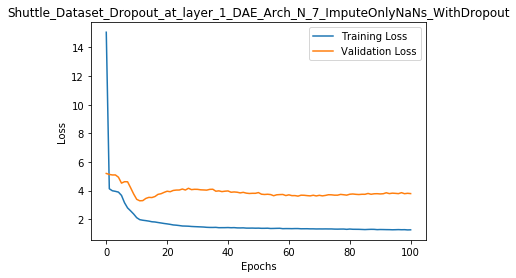

In [34]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

### Model 2 DAE_Arch_N_7_ImputeOnlyNaNs_With10PercentDropout

In [35]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.1, dropout_at_layers=[1])

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [36]:
model_name = "Shuttle_Dataset_Dropout_at_layer_1__DAE_Arch_N_7_ImputeOnlyNaNs_With10PercentDropout"

In [37]:
train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

Epoch number:9 Loss: 0.9182


Epoch number:19 Loss: 0.6841


Epoch number:29 Loss: 0.6387


Epoch number:39 Loss: 0.6234


Epoch number:49 Loss: 0.6302


Epoch number:59 Loss: 0.6087


Epoch number:69 Loss: 0.6023


Epoch number:79 Loss: 0.6031


Epoch number:89 Loss: 0.5920


Epoch number:99 Loss: 0.5943


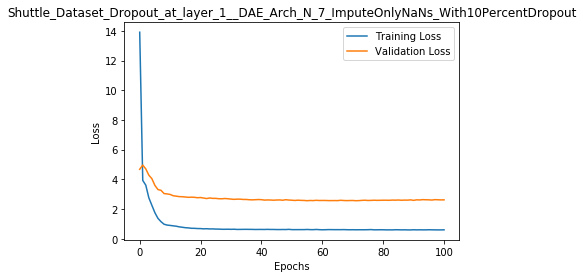

In [38]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [40]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,50,21,77,0,28,0.1,27,48,22
0,44,0,89,0,44.000000,4,45.000000,45.000000,0.000000
1,49,0,95,1,50.000000,7,47.000000,46.000000,0.000000
2,37,0,106,5,35.474241,0,38.064858,50.604037,13.635823
3,37,0,75,-2,26.000000,-15,38.000000,49.000000,10.000000
4,55,0,77,5,28.000000,0,22.000000,49.000000,26.000000


In [41]:
full_test_df.head()

,50,21,77,0,28,0.1,27,48,22
14601,44,0,89,0,44,4,45,45,0
3043,49,0,95,1,50,7,47,46,0
5667,37,0,106,5,18,0,69,88,18
36855,37,0,75,-2,26,-15,38,49,10
32389,55,0,77,5,28,0,22,49,26


In [42]:
test_df.head()

,50,21,77,0,28,0.1,27,48,22
14601,44,0,89,0,44.0,4,45.0,45.0,0.0
3043,49,0,95,1,50.0,7,47.0,46.0,0.0
5667,37,0,106,5,NaN,0,NaN,NaN,NaN
36855,37,0,75,-2,26.0,-15,38.0,49.0,10.0
32389,55,0,77,5,28.0,0,22.0,49.0,26.0


### Model 3 DAE_Arch_N_7_ImputeOnlyNaNs_WithNoDropout

In [16]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.0, dropout_at_layers=[1])

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [17]:
model_name = "Shuttle_Dataset_Dropout_at_layer_1__DAE_Arch_N_7_ImputeOnlyNaNs_WithNoDropout"

In [20]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 1.1553


Epoch number:19 Loss: 0.3985


Epoch number:29 Loss: 0.3196


Epoch number:39 Loss: 0.2983


Epoch number:49 Loss: 0.3234


Epoch number:59 Loss: 0.3036


Epoch number:69 Loss: 0.3070


Epoch number:79 Loss: 0.2611


Epoch number:89 Loss: 0.3423


Epoch number:99 Loss: 0.3294


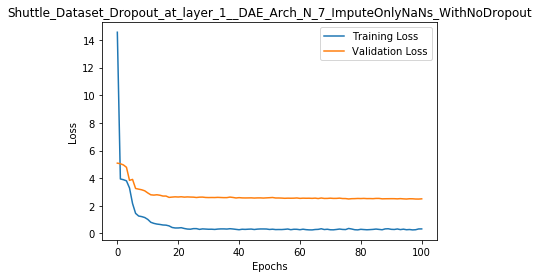

In [22]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [25]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,50,21,77,0,28,0.1,27,48,22
0,44,0,89,0,44.000000,4,45.000000,45.000000,0.000000
1,49,0,95,1,50.000000,7,47.000000,46.000000,0.000000
2,37,0,106,5,36.822591,0,36.548299,52.060161,15.351946
3,37,0,75,-2,26.000000,-15,38.000000,49.000000,10.000000
4,55,0,77,5,28.000000,0,22.000000,49.000000,26.000000


In [26]:
full_test_df.head() 

,50,21,77,0,28,0.1,27,48,22
14601,44,0,89,0,44,4,45,45,0
3043,49,0,95,1,50,7,47,46,0
5667,37,0,106,5,18,0,69,88,18
36855,37,0,75,-2,26,-15,38,49,10
32389,55,0,77,5,28,0,22,49,26


In [27]:
test_df.head()

,50,21,77,0,28,0.1,27,48,22
14601,44,0,89,0,44.0,4,45.0,45.0,0.0
3043,49,0,95,1,50.0,7,47.0,46.0,0.0
5667,37,0,106,5,NaN,0,NaN,NaN,NaN
36855,37,0,75,-2,26.0,-15,38.0,49.0,10.0
32389,55,0,77,5,28.0,0,22.0,49.0,26.0


### Model 4 DAE_Arch_N_3_ImputeOnlyNaNs_WithDropout

In [28]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 3, input_dropout=0.5, dropout_at_layers=[1])

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [29]:
model_name = "Shuttle_Dataset_Dropout_at_layer_1__DAE_Arch_N_3_ImputeOnlyNaNs_WithDropout"

In [30]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 1.9511


Epoch number:19 Loss: 1.7593


Epoch number:29 Loss: 1.6637


Epoch number:39 Loss: 1.5980


Epoch number:49 Loss: 1.5684


Epoch number:59 Loss: 1.5540


Epoch number:69 Loss: 1.5234


Epoch number:79 Loss: 1.5049


Epoch number:89 Loss: 1.4931


Epoch number:99 Loss: 1.4805


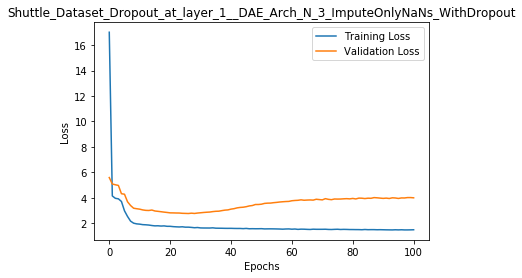

In [31]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [32]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,50,21,77,0,28,0.1,27,48,22
0,44,0,89,0,44.00000,4,45.000000,45.000000,0.000000
1,49,0,95,1,50.00000,7,47.000000,46.000000,0.000000
2,37,0,106,5,40.99222,0,49.521436,55.020125,5.767812
3,37,0,75,-2,26.00000,-15,38.000000,49.000000,10.000000
4,55,0,77,5,28.00000,0,22.000000,49.000000,26.000000


In [33]:
full_test_df.head() 

,50,21,77,0,28,0.1,27,48,22
14601,44,0,89,0,44,4,45,45,0
3043,49,0,95,1,50,7,47,46,0
5667,37,0,106,5,18,0,69,88,18
36855,37,0,75,-2,26,-15,38,49,10
32389,55,0,77,5,28,0,22,49,26


In [34]:
test_df.head()

,50,21,77,0,28,0.1,27,48,22
14601,44,0,89,0,44.0,4,45.0,45.0,0.0
3043,49,0,95,1,50.0,7,47.0,46.0,0.0
5667,37,0,106,5,NaN,0,NaN,NaN,NaN
36855,37,0,75,-2,26.0,-15,38.0,49.0,10.0
32389,55,0,77,5,28.0,0,22.0,49.0,26.0


### Model 5 DAE_Arch_N_3_ImputeOnlyNaNs_With10PercentDropout

In [35]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 3, input_dropout=0.1, dropout_at_layers=[1])

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [36]:
model_name = "Shuttle_Dataset_Dropout_at_layer_1__DAE_Arch_N_3_ImputeOnlyNaNs_With10PercentDropout"

In [37]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 1.3960


Epoch number:19 Loss: 0.9894


Epoch number:29 Loss: 0.9191


Epoch number:39 Loss: 0.7840


Epoch number:49 Loss: 0.7404


Epoch number:59 Loss: 0.7179


Epoch number:69 Loss: 0.7070


Epoch number:79 Loss: 0.6962


Epoch number:89 Loss: 0.6802


Epoch number:99 Loss: 0.6792


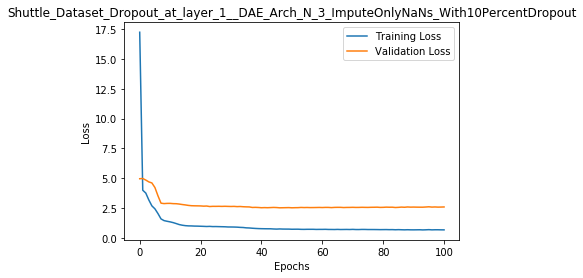

In [38]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [39]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,50,21,77,0,28,0.1,27,48,22
0,44,0,89,0,44.000000,4,45.000000,45.000000,0.000000
1,49,0,95,1,50.000000,7,47.000000,46.000000,0.000000
2,37,0,106,5,39.043961,0,38.791002,53.147175,15.359398
3,37,0,75,-2,26.000000,-15,38.000000,49.000000,10.000000
4,55,0,77,5,28.000000,0,22.000000,49.000000,26.000000


In [40]:
full_test_df.head() 

,50,21,77,0,28,0.1,27,48,22
14601,44,0,89,0,44,4,45,45,0
3043,49,0,95,1,50,7,47,46,0
5667,37,0,106,5,18,0,69,88,18
36855,37,0,75,-2,26,-15,38,49,10
32389,55,0,77,5,28,0,22,49,26


In [41]:
test_df.head()

,50,21,77,0,28,0.1,27,48,22
14601,44,0,89,0,44.0,4,45.0,45.0,0.0
3043,49,0,95,1,50.0,7,47.0,46.0,0.0
5667,37,0,106,5,NaN,0,NaN,NaN,NaN
36855,37,0,75,-2,26.0,-15,38.0,49.0,10.0
32389,55,0,77,5,28.0,0,22.0,49.0,26.0


### Model 7 DAE_Arch_N_9_ImputeOnlyNaNs_WithNoDropout

In [43]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 9, input_dropout=0.0, dropout_at_layers=[1])

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [44]:
model_name = "Shuttle_Dataset_Dropout_at_layer_1__DAE_Arch_N_9_ImputeOnlyNaNs_WithNoDropout"

In [45]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 0.7246


Epoch number:19 Loss: 0.3532


Epoch number:29 Loss: 0.3224


Epoch number:39 Loss: 0.3450


Epoch number:49 Loss: 0.3834


Epoch number:59 Loss: 0.3049


Epoch number:69 Loss: 0.3133


Epoch number:79 Loss: 0.3385


Epoch number:89 Loss: 0.2763


Epoch number:99 Loss: 0.2739


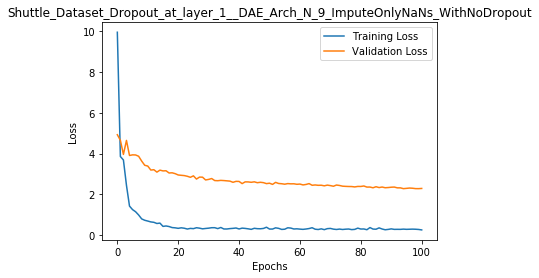

In [46]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [47]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,50,21,77,0,28,0.1,27,48,22
0,44,0,89,0,44.000000,4,45.000000,45.000000,0.0000
1,49,0,95,1,50.000000,7,47.000000,46.000000,0.0000
2,37,0,106,5,37.016535,0,36.275722,50.359772,14.4093
3,37,0,75,-2,26.000000,-15,38.000000,49.000000,10.0000
4,55,0,77,5,28.000000,0,22.000000,49.000000,26.0000


In [48]:
full_test_df.head() 

,50,21,77,0,28,0.1,27,48,22
14601,44,0,89,0,44,4,45,45,0
3043,49,0,95,1,50,7,47,46,0
5667,37,0,106,5,18,0,69,88,18
36855,37,0,75,-2,26,-15,38,49,10
32389,55,0,77,5,28,0,22,49,26


In [49]:
test_df.head()

,50,21,77,0,28,0.1,27,48,22
14601,44,0,89,0,44.0,4,45.0,45.0,0.0
3043,49,0,95,1,50.0,7,47.0,46.0,0.0
5667,37,0,106,5,NaN,0,NaN,NaN,NaN
36855,37,0,75,-2,26.0,-15,38.0,49.0,10.0
32389,55,0,77,5,28.0,0,22.0,49.0,26.0
